# Customer  Life Time value (CLTV) (New)

In [1]:
import pandas as pd
import numpy as np
import warnings
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats

In [2]:
warnings.filterwarnings('ignore')

In [3]:
New_data = pd.read_csv('New_final.csv').drop('Unnamed: 0',axis = 1)

In [4]:
New_data

,Member_number,Date,itemDescription,Sales,Year
0,1808,2015-07-21,tropical fruit,7.95,2015
1,2552,2015-05-01,whole milk,25.92,2015
2,2300,2015-09-19,pip fruit,8.96,2015
3,1187,2015-12-12,other vegetables,32.20,2015
4,3037,2015-01-02,whole milk,12.96,2015
...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,7.12,2014
38761,2022,2014-02-23,candy,11.00,2014
38762,1097,2014-04-16,cake bar,9.90,2014
38763,1510,2014-03-12,fruit/vegetable juice,2.21,2014


# Data Preprocessing

In [9]:
#Data was imported after preprocessing, still checking them once to make sure if the data is processed for fitting

In [5]:
#Check Null values
New_data.isnull().sum()

Member_number      0
Date               0
itemDescription    0
Sales              0
Year               0
dtype: int64

In [6]:
#Check Duplicates
New_data.duplicated().sum()

124

In [ ]:
#Not dropping duplicates cause duplicates must not be dropped in time series data as it causes temporal aggregation

<AxesSubplot:>

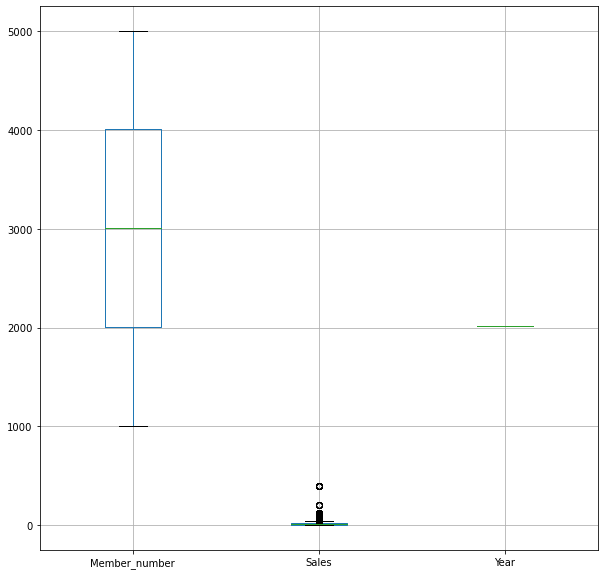

In [8]:
#check outlier
New_data.boxplot(figsize = (10,10))

array([[<AxesSubplot:title={'center':'Member_number'}>,
        <AxesSubplot:title={'center':'Sales'}>],
       [<AxesSubplot:title={'center':'Year'}>, <AxesSubplot:>]],
      dtype=object)

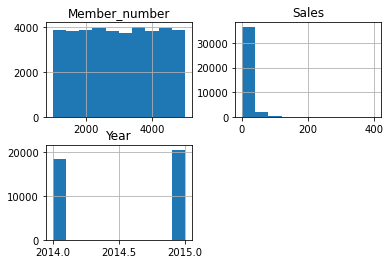

In [10]:
#Checking skweness of the data
New_data.hist()

In [12]:
#checking summary
New_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Member_number,38765.0,3003.641868,1153.611031,1000.00,2002.0,3005.00,4007.00,5000.0
Sales,38765.0,15.812160,16.544494,0.33,5.7,11.13,20.93,400.0
Year,38765.0,2014.528518,0.499193,2014.00,2014.0,2015.00,2015.00,2015.0


In [13]:
#Checking dtypes
New_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Member_number    38765 non-null  int64  
 1   Date             38765 non-null  object 
 2   itemDescription  38765 non-null  object 
 3   Sales            38765 non-null  float64
 4   Year             38765 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.5+ MB


In [5]:
#Converting object to datetime
New_data['Date'] = pd.to_datetime(New_data['Date'])

In [15]:
New_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
 3   Sales            38765 non-null  float64       
 4   Year             38765 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.5+ MB


In [16]:
New_data.head()

,Member_number,Date,itemDescription,Sales,Year
0,1808,2015-07-21,tropical fruit,7.95,2015
1,2552,2015-05-01,whole milk,25.92,2015
2,2300,2015-09-19,pip fruit,8.96,2015
3,1187,2015-12-12,other vegetables,32.20,2015
4,3037,2015-01-02,whole milk,12.96,2015


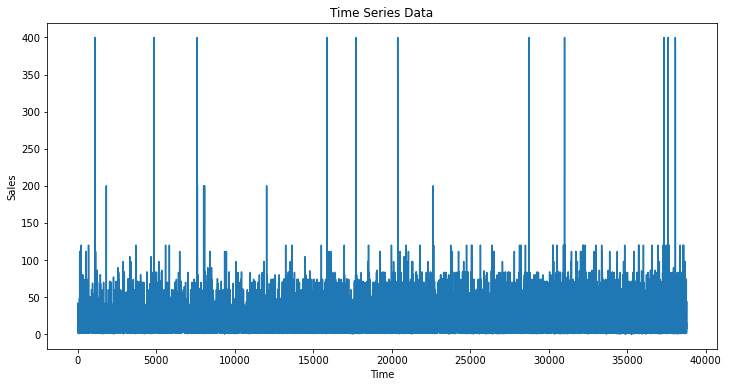

ADF Statistic: -195.4537736663755
p-value: 0.0
Critical Values:
1%: -3.430518706353408
5%: -2.8616145642671476
10%: -2.56680968817625
The time series is stationary (reject the null hypothesis)


In [17]:
#Checking if data is stationary or not
from statsmodels.tsa.stattools import adfuller

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(New_data['Sales'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

# Perform the Augmented Dickey-Fuller test
result = adfuller(New_data['Sales'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

# Interpret the test results
if result[1] <= 0.05:
    print("The time series is stationary (reject the null hypothesis)")
else:
    print("The time series is not stationary (fail to reject the null hypothesis)")

In [26]:
#Checking Correlation (Feature) (Useless to be honest cause we dont have much attributes)
New_data.corr()

,Member_number,Sales,Year
Member_number,1.000000,0.003764,-0.003019
Sales,0.003764,1.000000,-0.002481
Year,-0.003019,-0.002481,1.000000


<AxesSubplot:>

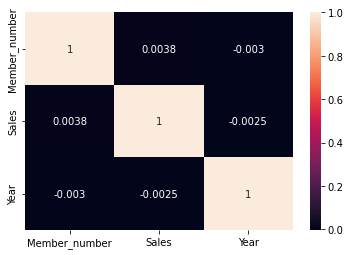

In [29]:
sns.heatmap(New_data.corr(), annot = True)

In [5]:
New_data['Member_number'].nunique()

3898

In [6]:
New_data['itemDescription'].nunique()

167

In [7]:
New_data['itemDescription'].unique()

array(['tropical fruit', 'whole milk', 'pip fruit', 'other vegetables',
       'rolls/buns', 'pot plants', 'citrus fruit', 'beef', 'frankfurter',
       'chicken', 'butter', 'fruit/vegetable juice',
       'packaged fruit/vegetables', 'chocolate', 'specialty bar',
       'butter milk', 'bottled water', 'yogurt', 'sausage', 'brown bread',
       'hamburger meat', 'root vegetables', 'pork', 'pastry',
       'canned beer', 'berries', 'coffee', 'misc. beverages', 'ham',
       'turkey', 'curd cheese', 'red/blush wine',
       'frozen potato products', 'flour', 'sugar', 'frozen meals',
       'herbs', 'soda', 'detergent', 'grapes', 'processed cheese', 'fish',
       'sparkling wine', 'newspapers', 'curd', 'pasta', 'popcorn',
       'finished products', 'beverages', 'bottled beer', 'dessert',
       'dog food', 'specialty chocolate', 'condensed milk', 'cleaner',
       'white wine', 'meat', 'ice cream', 'hard cheese', 'cream cheese ',
       'liquor', 'pickled vegetables', 'liquor (appetizer

In [8]:
New_data['Member_number'].unique()

array([1808, 2552, 2300, ..., 3607, 4587, 2417], dtype=int64)

In [9]:
New_data['Year'].unique()

array([2015, 2014], dtype=int64)

In [10]:
#Select only Customers who has more than 10 transcations recorded
selected_members_10 = []
for i in New_data['Member_number'].unique():
    if len(New_data[New_data['Member_number'] == i])>10:
        selected_members_10.append(i)

In [6]:
#Select only Customers who has more than 20 transcations recorded
selected_members_20 = []
for i in New_data['Member_number'].unique():
    if len(New_data[New_data['Member_number'] == i])>20:
        selected_members_20.append(i)

In [12]:
#Original Customers
New_data['Member_number'].nunique()

3898

In [13]:
#Only Customers with more than 10 transactions
len(selected_members_10)

1598

In [14]:
#Only Customers with more than 20 transactions
len(selected_members_20)

161

In [15]:
selected_members_20[0:5]

[4941, 2193, 1997, 2421, 1905]

In [7]:
Final_data = pd.DataFrame()
for i in selected_members_20:
    Final_data = Final_data.append(New_data[New_data['Member_number'] == i])
Final_data.reset_index(inplace = True,drop = True)

In [8]:
Final_data

,Member_number,Date,itemDescription,Sales,Year
0,4941,2015-02-14,rolls/buns,7.20,2015
1,4941,2015-01-15,rolls/buns,7.20,2015
2,4941,2015-01-15,canned beer,8.55,2015
3,4941,2015-01-15,bottled beer,70.00,2015
4,4941,2015-01-15,ham,19.04,2015
...,...,...,...,...,...
3803,1169,2014-05-29,whipped/sour cream,5.70,2014
3804,1169,2014-01-25,white bread,4.50,2014
3805,1169,2014-04-15,napkins,3.28,2014
3806,1169,2014-05-06,cleaner,60.00,2014


In [18]:
Final_data['Member_number'].nunique()

161

In [19]:
Final_data[Final_data['Member_number'] == 4941]

,Member_number,Date,itemDescription,Sales,Year
0,4941,2015-02-14,rolls/buns,7.20,2015
1,4941,2015-01-15,rolls/buns,7.20,2015
2,4941,2015-01-15,canned beer,8.55,2015
3,4941,2015-01-15,bottled beer,70.00,2015
4,4941,2015-01-15,ham,19.04,2015
5,4941,2014-09-09,coffee,2.70,2014
6,4941,2014-12-06,whole milk,21.60,2014
7,4941,2014-04-13,liquor,23.80,2014
8,4941,2014-08-02,yogurt,16.10,2014
9,4941,2014-02-24,white wine,14.00,2014


In [20]:
len(selected_members_20)

161

# Model Performances

In [95]:
model_1 = []
model_2 = []
model_3 = []
model_4 = []

# ARIMA Model (Auto-Regression Integrated Moving Average)

In [13]:
Error = []
for i in selected_members_20:
    a = Final_data[Final_data['Member_number'] == i]
    
    model = ARIMA(a['Sales'].iloc[0:-2])
    model_fit = model.fit()
    
    #Forcast
    ypred = model_fit.forecast(2)
    
    Error.append(np.sqrt(mean_squared_error(np.array(a['Sales'].iloc[-2:]), np.array(ypred))))

In [142]:
#Original for customer 4921
a['Sales'].iloc[-2:]

3806    60.0
3807    20.0
Name: Sales, dtype: float64

# Predicted/Forecasted

In [143]:
#Forcasted for customer 4921
ypred

19    14.3621
20    14.3621
Name: predicted_mean, dtype: float64

In [144]:
#RMSE for customer 4921
np.sqrt(mean_squared_error(np.array(a['Sales'].iloc[-2:]), np.array(ypred)))

32.51617914761352

In [145]:
for i in range(len(Error)):
    print('The RMSE for Forcasted Customer',selected_members_20[i],'is',Error[i])

The RMSE for Forcasted Customer 4941 is 11.974430366258867
The RMSE for Forcasted Customer 2193 is 8.8362389285867
The RMSE for Forcasted Customer 1997 is 9.01953765523751
The RMSE for Forcasted Customer 2421 is 12.428152640300464
The RMSE for Forcasted Customer 1905 is 8.766082323130163
The RMSE for Forcasted Customer 4783 is 14.1647100718013
The RMSE for Forcasted Customer 3709 is 21.24330907945537
The RMSE for Forcasted Customer 4272 is 9.305697413959948
The RMSE for Forcasted Customer 2632 is 11.149163512693693
The RMSE for Forcasted Customer 2270 is 14.625245049928953
The RMSE for Forcasted Customer 3811 is 6.389020292537512
The RMSE for Forcasted Customer 4875 is 11.746683831838821
The RMSE for Forcasted Customer 2022 is 5.389648003320452
The RMSE for Forcasted Customer 4293 is 51.61657026705207
The RMSE for Forcasted Customer 2560 is 22.89048050465031
The RMSE for Forcasted Customer 2990 is 10.688028669929505
The RMSE for Forcasted Customer 3635 is 12.766181295520214
The RMSE fo

In [146]:
#Total Rmse for All Customer
print('The Total RMSE of All Customer is for ARIMA:-',sum(Error)/len(Error))

The Total RMSE of All Customer is for ARIMA:- 13.422907825203396


In [147]:
model_1.append(sum(Error)/len(Error))

### Random Model RMSE Check to wheather our CLTV model is forecasting usefull

In [148]:
A = pd.DataFrame()
for i in selected_members_20:
    A = A.append(Final_data[Final_data['Member_number'] == i])

A.describe()

,Member_number,Sales,Year
count,3808.00000,3808.000000,3808.000000
mean,3043.90730,15.850097,2014.600578
std,1093.83799,15.168624,0.489844
min,1004.00000,0.330000,2014.000000
25%,2193.00000,5.700000,2014.000000
50%,3050.00000,11.130000,2015.000000
75%,3915.00000,21.000000,2015.000000
max,4941.00000,120.000000,2015.000000


In [149]:
#Creating Random values to check the rsme of the algorithm prediction
random_error = []
random_values = pd.DataFrame(index = range(190*20))
random_values['Member_number'] = 0
random_values['Sales'] = 0
random_values['Year'] = 2014

twenties = []
count = 1

for i in range(random_values.shape[0]):
    if i == 0:
        continue
    else:
        if 20*i> random_values.shape[0]:
            break
        else:
            twenties.append(20*i)
            
for i in range(random_values.shape[0]):
    if i+1==twenties[0]:
        random_values['Member_number'][i] = count
        del twenties[0]
        count = count +1
    else:
        random_values['Member_number'][i] = count
        
original_data = Final_data.Sales
kde = stats.gaussian_kde(original_data)
num_samples = 3800  # Set the number of random samples you want to generate
random_numbers = kde.resample(num_samples)
random_numbers = sum(random_numbers.tolist(),[])

random_values['Sales'] = random_numbers

In [150]:
for i in range(162):
    if i ==0:
        continue
    else:
        a = random_values[random_values['Member_number'] == i]
    
        model = ARIMA(a['Sales'].iloc[0:-2], order = (1,1,1))
        model_fit = model.fit()
    
        #Forcast
        ypred = model_fit.forecast(2)
    
        random_error.append(np.sqrt(mean_squared_error(np.array(a['Sales'].iloc[-2:]), np.array(ypred))))

In [151]:
#Total Rmse for ARIMA Random Model
print('The Total RMSE of All Customer is for ARIMA RANDOM:-',sum(random_error)/len(random_error))

The Total RMSE of All Customer is for ARIMA RANDOM:- 14.53351666512448


In [152]:
def create_line_plot(x_values, y_values):
    plt.plot(x_values, y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('RMSE Plot')
    plt.show()

# Example data
y_values = []
for i in range(len(Error)):
    y_values.append(i)
    
y_values1 = []
for i in range(len(random_error)):
    y_values1.append(i)

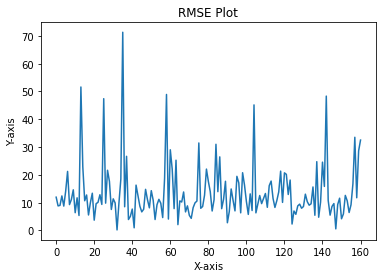

In [153]:
#ARIMA Error Plot
create_line_plot(y_values,Error)

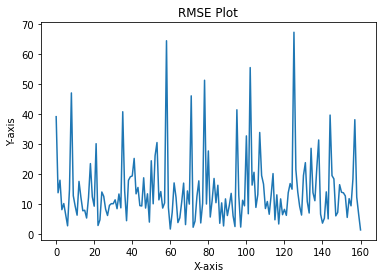

In [154]:
#ARIMA Random Error Plot
create_line_plot(y_values1,random_error)

# SES Model (Single Exponential Smoothing)

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [156]:
Error1 = []
for i in selected_members_20:
    a = Final_data[Final_data['Member_number'] == i]
    
    model = ExponentialSmoothing(a['Sales'].iloc[0:-2])
    ypred = model_fit.forecast(2)
    
    Error1.append(np.sqrt(mean_squared_error(np.array(a['Sales'].iloc[-2:]), np.array(ypred))))

In [157]:
for i in range(len(Error1)):
    print('The RMSE for Forcasted Customer',selected_members_20[i],'is',Error1[i])

The RMSE for Forcasted Customer 4941 is 10.1501094387984
The RMSE for Forcasted Customer 2193 is 2.995538265146454
The RMSE for Forcasted Customer 1997 is 7.002921758509045
The RMSE for Forcasted Customer 2421 is 13.235110371306062
The RMSE for Forcasted Customer 1905 is 7.273773856754359
The RMSE for Forcasted Customer 4783 is 7.96547397699096
The RMSE for Forcasted Customer 3709 is 23.006277440809296
The RMSE for Forcasted Customer 4272 is 9.505527122079258
The RMSE for Forcasted Customer 2632 is 9.725285139089223
The RMSE for Forcasted Customer 2270 is 7.800973772111943
The RMSE for Forcasted Customer 3811 is 7.401780139522983
The RMSE for Forcasted Customer 4875 is 11.910828782590063
The RMSE for Forcasted Customer 2022 is 2.885849840184399
The RMSE for Forcasted Customer 4293 is 51.437380533466104
The RMSE for Forcasted Customer 2560 is 25.8949323990853
The RMSE for Forcasted Customer 2990 is 11.559912052177848
The RMSE for Forcasted Customer 3635 is 13.5925571589085
The RMSE for 

In [158]:
#Total Rmse for All Customer
print('The Total RMSE of All Customer is for SES-',sum(Error1)/len(Error1))

The Total RMSE of All Customer is for SES- 12.806686303856837


In [159]:
model_2.append(sum(Error1)/len(Error1))

### Random Model RMSE Check to wheather our CLTV model is forecasting usefull

In [160]:
random_error1 = []
for i in range(162):
    if i ==0:
        continue
    else:
        a = random_values[random_values['Member_number'] == i]
    
        model = ExponentialSmoothing(a['Sales'].iloc[0:-2])
        model_fit = model.fit()
    
        #Forcast
        ypred = model_fit.forecast(2)
    
        random_error1.append(np.sqrt(mean_squared_error(np.array(a['Sales'].iloc[-2:]), np.array(ypred))))

In [161]:
#Total Rmse for SES Random Model
print('The Total RMSE of All Customer is for SES RANDOM:-',sum(random_error1)/len(random_error1))

The Total RMSE of All Customer is for SES RANDOM:- 13.428692841846255


In [162]:
def create_line_plot(x_values, y_values):
    plt.plot(x_values, y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('RMSE Plot')
    plt.show()

# Example data
y_values = []
for i in range(len(Error1)):
    y_values.append(i)

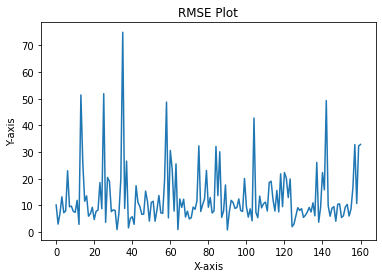

In [163]:
#SES Error Plot
create_line_plot(y_values,Error1)

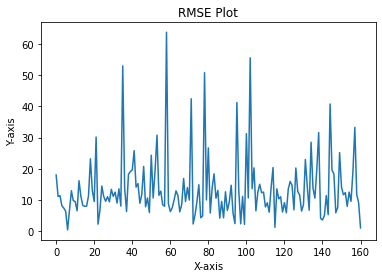

In [164]:
#Random SES Error Plot
create_line_plot(y_values,random_error1)

# HWES Model (Holt Winter’s Exponential Smoothing)

In [165]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

In [166]:
Error2 = []

for i in selected_members_20:
    a = Final_data[Final_data['Member_number'] == i]

    model = HWES(a['Sales'].iloc[0:-2],trend='add')
    ypred = model_fit.forecast(2)
    
    Error2.append(np.sqrt(mean_squared_error(np.array(a['Sales'].iloc[-2:]), np.array(ypred))))

In [167]:
for i in range(len(Error2)):
    print('The RMSE for Forcasted Customer',selected_members_20[i],'is',Error2[i])

The RMSE for Forcasted Customer 4941 is 10.584447049690256
The RMSE for Forcasted Customer 2193 is 2.5419616176156894
The RMSE for Forcasted Customer 1997 is 7.3555242842974415
The RMSE for Forcasted Customer 2421 is 13.341816103032686
The RMSE for Forcasted Customer 1905 is 7.790450196447677
The RMSE for Forcasted Customer 4783 is 8.440073901261504
The RMSE for Forcasted Customer 3709 is 22.796517111130623
The RMSE for Forcasted Customer 4272 is 9.269482044471037
The RMSE for Forcasted Customer 2632 is 10.13261498867286
The RMSE for Forcasted Customer 2270 is 8.176497581522105
The RMSE for Forcasted Customer 3811 is 7.864958109332311
The RMSE for Forcasted Customer 4875 is 12.405128174237317
The RMSE for Forcasted Customer 2022 is 2.732135995127712
The RMSE for Forcasted Customer 4293 is 50.92465554176973
The RMSE for Forcasted Customer 2560 is 25.937969536307584
The RMSE for Forcasted Customer 2990 is 11.492910192777256
The RMSE for Forcasted Customer 3635 is 13.04467041568943
The RM

In [168]:
#Total Rmse for All Customer
print('The Total RMSE of All Customer is for HWES-',sum(Error2)/len(Error2))

The Total RMSE of All Customer is for HWES- 12.896545359347424


In [169]:
model_3.append(sum(Error2)/len(Error2))

### Random Model RMSE Check to wheather our CLTV model is forecasting usefull

In [170]:
random_error2 = []
for i in range(162):
    if i ==0:
        continue
    else:
        a = random_values[random_values['Member_number'] == i]
    
        model = HWES(a['Sales'].iloc[0:-2])
        model_fit = model.fit()
    
        #Forcast
        ypred = model_fit.forecast(2)
    
        random_error2.append(np.sqrt(mean_squared_error(np.array(a['Sales'].iloc[-2:]), np.array(ypred))))

In [171]:
#Total Rmse for HWES Random Model
print('The Total RMSE of All Customer is for HWES RANDOM:-',sum(random_error2)/len(random_error2))

The Total RMSE of All Customer is for HWES RANDOM:- 13.428692841846255


In [172]:
def create_line_plot(x_values, y_values):
    plt.plot(x_values, y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('RMSE Plot')
    plt.show()

# Example data
y_values = []
for i in range(len(Error2)):
    y_values.append(i)

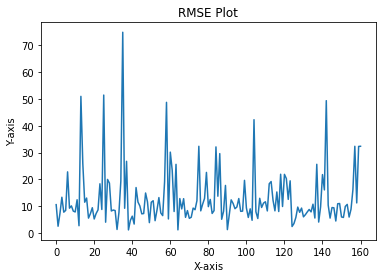

In [173]:
#HWES Error Plot
create_line_plot(y_values,Error2)

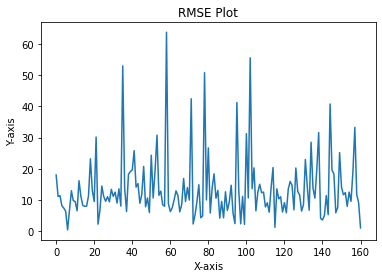

In [174]:
#HWES RANDOM Error Plot
create_line_plot(y_values,random_error2)

# XGBoost Model

In [17]:
from xgboost import XGBRegressor

In [18]:
Error4 = []

for i in selected_members_20:
    a = Final_data[Final_data['Member_number'] == i]
    a.reset_index(inplace = True)
    a.rename({'index':'Transactions'},axis = 1,inplace = True)
    
    X_train, X_test, y_train, y_test = train_test_split(a['Transactions'], a['Sales'], test_size=0.10, random_state=100)
    model = XGBRegressor()
    model.fit(X_train,y_train)

    ypred = model.predict(X_test)

    Error4.append(np.sqrt(mean_squared_error(np.array(y_test), np.array(ypred))))

In [177]:
a.head()

,Transactions,Member_number,Date,itemDescription,Sales,Year
0,3787,1169,2014-05-29,finished products,37.31,2014
1,3788,1169,2014-01-15,other vegetables,9.20,2014
2,3789,1169,2014-01-11,soda,4.20,2014
3,3790,1169,2014-04-01,liquor,83.30,2014
4,3791,1169,2014-01-25,waffles,8.40,2014


In [178]:
for i in range(len(Error4)):
    print('The RMSE for Forcasted Customer',selected_members_20[i],'is',Error4[i])

The RMSE for Forcasted Customer 4941 is 15.025671295948323
The RMSE for Forcasted Customer 2193 is 50.62559162164386
The RMSE for Forcasted Customer 1997 is 10.007808442981279
The RMSE for Forcasted Customer 2421 is 20.466368478343757
The RMSE for Forcasted Customer 1905 is 33.342296918295375
The RMSE for Forcasted Customer 4783 is 4.600656373693438
The RMSE for Forcasted Customer 3709 is 16.155274680781886
The RMSE for Forcasted Customer 4272 is 20.154777495871073
The RMSE for Forcasted Customer 2632 is 13.639886887448585
The RMSE for Forcasted Customer 2270 is 15.35856650609194
The RMSE for Forcasted Customer 3811 is 7.38583616187067
The RMSE for Forcasted Customer 4875 is 16.81626639163561
The RMSE for Forcasted Customer 2022 is 55.0047761276238
The RMSE for Forcasted Customer 4293 is 48.52274500591059
The RMSE for Forcasted Customer 2560 is 10.370344849520384
The RMSE for Forcasted Customer 2990 is 9.151540391303142
The RMSE for Forcasted Customer 3635 is 23.77979181212612
The RMSE

In [179]:
#Total Rmse for XGBoost Random Model
print('The Total RMSE of All Customer is for XGBoost:-',sum(Error4)/len(Error4))

The Total RMSE of All Customer is for XGBoost:- 19.14011987155644


In [180]:
model_4.append(sum(Error4)/len(Error4))

### Random Model RMSE Check to wheather our CLTV model is forecasting usefull

In [57]:
random_error4 = []
for i in range(162):
    if i ==0:
        continue
    else:
        a = random_values[random_values['Member_number'] == i]
        a.reset_index(inplace = True)
        a.rename({'index':'Transactions'},axis = 1,inplace = True)
    
        X_train, X_test, y_train, y_test = train_test_split(a['Transactions'], a['Sales'], test_size=0.10,random_state=100)
        model = XGBRegressor()
        model.fit(X_train,y_train)
    
        #Forcast
        ypred = model.predict(X_test)
    
        random_error4.append(np.sqrt(mean_squared_error(np.array(y_test), np.array(ypred))))

In [58]:
#Total Rmse for XGBOOST Random Model
print('The Total RMSE of All Customer is for XGBOOST RANDOM:-',sum(random_error4)/len(random_error4))

The Total RMSE of All Customer is for XGBOOST RANDOM:- 17.01099806434836


In [59]:
def create_line_plot(x_values, y_values):
    plt.plot(x_values, y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('RMSE Plot')
    plt.show()

# Example data
y_values = []
for i in range(len(Error4)):
    y_values.append(i)

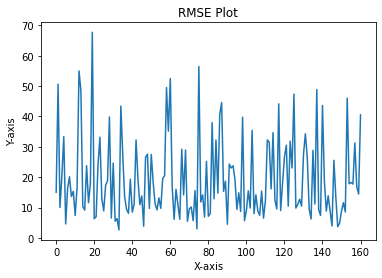

In [60]:
#XGBOOST Error Plot
create_line_plot(y_values,Error4)

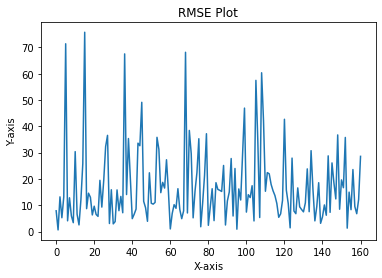

In [61]:
#XGBOOST RANDOM Error Plot
create_line_plot(y_values,random_error4)

In [62]:
Final_data.Sales.shape

(3808,)

# Students Paired T-test

In [63]:
A = random_values.Sales
B = Final_data.Sales.iloc[0:3800]
Differences = A-B

In [64]:
Differences

0       14.421238
1        1.949105
2       -7.280826
3      -59.529746
4      -13.709504
          ...    
3795    -1.121315
3796    52.179307
3797   -11.455242
3798    -8.199005
3799   -22.297727
Name: Sales, Length: 3800, dtype: float64

In [65]:
N = len(Differences)
Dmean = sum(Differences)/len(Differences)
SD = np.std(Differences)

#Degrees of Freedom to get the value from T-table
DF = N-1 

In [66]:
#number of Samples
N

3800

In [67]:
#Differences Mean
Dmean

-0.2763947054941052

In [68]:
#Standard Deviation
SD

21.88844484101403

In [69]:
#Degree of Freedom
DF

3799

In [70]:
#T-Value
T = (Dmean*math.sqrt(N))/SD

In [71]:
#Ignore the (-) minus
T

-0.7784067827887838

# T-Test Package

In [72]:
import researchpy as rp
import scipy.stats as stats

In [73]:
#Random Generated
A

0       21.621238
1        9.149105
2        1.269174
3       10.470254
4        5.330496
          ...    
3795     1.188685
3796    55.959307
3797    14.464758
3798     0.840995
3799    -2.617727
Name: Sales, Length: 3800, dtype: float64

In [74]:
#Original
B

0        7.20
1        7.20
2        8.55
3       70.00
4       19.04
        ...  
3795     2.31
3796     3.78
3797    25.92
3798     9.04
3799    19.68
Name: Sales, Length: 3800, dtype: float64

# T-TEST USING RESEARCHPY

In [75]:
rp.ttest(group1=A , group2=B)

(   Variable       N       Mean         SD        SE  95% Conf.   Interval
 0     Sales  3800.0  15.572087  15.522959  0.251816  15.078380  16.065794
 1     Sales  3800.0  15.848482  15.162649  0.245971  15.366234  16.330729
 2  combined  7600.0  15.710284  15.343475  0.176002  15.365272  16.055296,
               Independent t-test    results
 0  Difference (Sales - Sales) =     -0.2764
 1          Degrees of freedom =   7598.0000
 2                           t =     -0.7852
 3       Two side test p value =      0.4324
 4      Difference < 0 p value =      0.2162
 5      Difference > 0 p value =      0.7838
 6                   Cohen's d =     -0.0180
 7                   Hedge's g =     -0.0180
 8              Glass's delta1 =     -0.0178
 9            Point-Biserial r =     -0.0090)

# T-TEST USING SCIPY.STATS

In [76]:
stats.ttest_ind(A,B)

Ttest_indResult(statistic=-0.7851847125191174, pvalue=0.43236975929880006)

# Anova Test

In [186]:
import scipy.stats as stats

# Perform the ANOVA test
f_statistic, p_value = stats.f_oneway(model_1,model_2,model_3,model_4)

print("The P-value for four different models by comparing the MSE and mesure the ratio of variance:- ",p_value)
# Set your significance level (alpha)
alpha = 0.05

# Interpret the results
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in model performance.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in model performance.")

# Optionally, you can perform post hoc tests if the ANOVA is significant to identify specific differences between groups.


The P-value for four different models by comparing the MSE and mesure the ratio of variance:-  0.05563465599835963
Fail to reject the null hypothesis: There is no significant difference in model performance.


# Super Market Recommendation

In [9]:
New_data.head()

,Member_number,Date,itemDescription,Sales,Year
0,1808,2015-07-21,tropical fruit,7.95,2015
1,2552,2015-05-01,whole milk,25.92,2015
2,2300,2015-09-19,pip fruit,8.96,2015
3,1187,2015-12-12,other vegetables,32.20,2015
4,3037,2015-01-02,whole milk,12.96,2015


In [6]:
recommend = New_data.set_index(['Date'])

In [7]:
recommend.index = pd.to_datetime(recommend.index)

In [8]:
recommend.head()

,Member_number,itemDescription,Sales,Year
Date,,,,
2015-07-21,1808,tropical fruit,7.95,2015
2015-05-01,2552,whole milk,25.92,2015
2015-09-19,2300,pip fruit,8.96,2015
2015-12-12,1187,other vegetables,32.20,2015
2015-01-02,3037,whole milk,12.96,2015


In [10]:
total_items = len(recommend)
total_days = len(np.unique(recommend.index.date))
total_months = len(np.unique(recommend.index.month))
average_items = total_items / total_days
unique_items = recommend.itemDescription.unique().size

print("There are {} unique items sold ".format(unique_items))
print("Total {} items sold in {} days throughout {} months".format(total_items, total_days, total_months))
print("With an average of {} items sold daily".format(average_items))

There are 167 unique items sold 
Total 38765 items sold in 728 days throughout 12 months
With an average of 53.24862637362637 items sold daily


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Number of total Items Sold')]

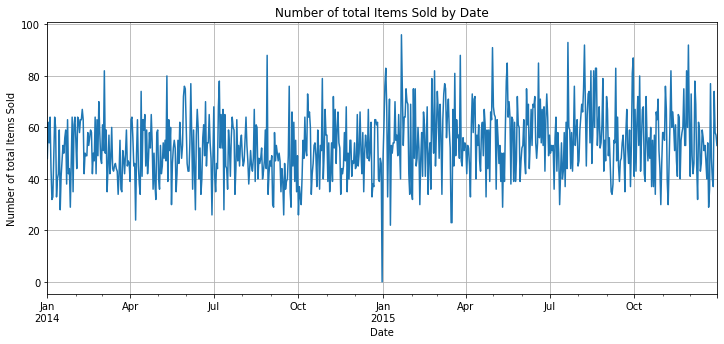

In [11]:
recommend.resample("D")['itemDescription'].count().plot(figsize=(12,5), grid=True, title="Number of total Items Sold by Date").set(xlabel="Date", ylabel="Number of total Items Sold")

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Number of Total Items Sold')]

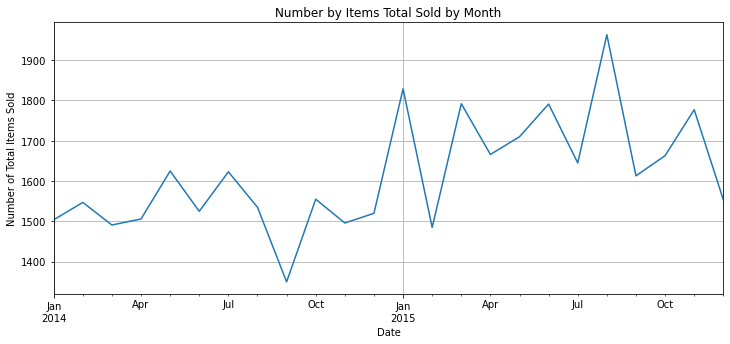

In [13]:
recommend.resample("M")['itemDescription'].count().plot(figsize=(12,5), grid=True, title="Number by Items Total Sold by Month").set(xlabel="Date", ylabel="Number of Total Items Sold")

In [14]:
recommend["Weekday"] = recommend.index.weekday + 1
recommend["Hour"] =recommend.index.hour

In [23]:
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder

TE = TransactionEncoder()

In [17]:
items_transactions = [a[1]['itemDescription'].tolist() for a in list(recommend.groupby(['Member_number','Date']))]

In [21]:
print("all items transactions are:-",items_transactions)

all items transactions are:- [['whole milk', 'pastry', 'salty snack'], ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'], ['soda', 'pickled vegetables'], ['canned beer', 'misc. beverages'], ['sausage', 'hygiene articles'], ['sausage', 'whole milk', 'rolls/buns'], ['whole milk', 'soda'], ['frankfurter', 'soda', 'whipped/sour cream'], ['frankfurter', 'curd'], ['beef', 'white bread'], ['butter', 'whole milk'], ['frozen vegetables', 'other vegetables'], ['tropical fruit', 'sugar'], ['butter milk', 'specialty chocolate'], ['frozen meals', 'dental care'], ['rolls/buns', 'rolls/buns'], ['root vegetables', 'detergent'], ['sausage', 'rolls/buns'], ['dish cleaner', 'cling film/bags'], ['canned beer', 'frozen fish'], ['pip fruit', 'whole milk', 'tropical fruit'], ['root vegetables', 'whole milk', 'pastry'], ['rolls/buns', 'red/blush wine', 'chocolate'], ['other vegetables', 'shopping bags'], ['whole milk', 'chocolate', 'packaged fruit/vegetables', 'rolls/buns'], ['other vegetables', 'hyg

In [25]:
transformed = TE.fit(items_transactions).transform(items_transactions)

In [27]:
all_transactions = pd.DataFrame(transformed , columns=TE.columns_)
pf = all_transactions.describe()

In [28]:
pf

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
count,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,...,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,14903,14643,14941,14934,14960,14959,14842,14946,14455,14637,...,14883,14912,14686,14309,14955,14604,14788,12600,13678,14903


In [29]:
#REFERENCED FROM KAGGLE

f = pf.iloc[0]-pf.iloc[3]
a = f.tolist()
b = list(f.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])
item = item.sort_values(['Count'], ascending=False).head(50)

In [30]:
item

,Count,Item
164,2363,whole milk
102,1827,other vegetables
122,1646,rolls/buns
138,1453,soda
165,1285,yogurt
123,1041,root vegetables
156,1014,tropical fruit
12,908,bottled water
130,903,sausage
30,795,citrus fruit


In [31]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [36]:
all_transactions.rename(columns=lambda x: x.title(), inplace=True)

In [37]:
all_transactions

,Instant Food Products,Uht-Milk,Abrasive Cleaner,Artif. Sweetener,Baby Cosmetics,Bags,Baking Powder,Bathroom Cleaner,Beef,Berries,...,Turkey,Vinegar,Waffles,Whipped/Sour Cream,Whisky,White Bread,White Wine,Whole Milk,Yogurt,Zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
frequqncy_of_items = apriori(all_transactions, min_support=0.001, use_colnames=True, verbose=1)
frequqncy_of_items

Processing 28 combinations | Sampling itemset size 4e 3


,support,itemsets
0,0.004010,(Instant Food Products)
1,0.021386,(Uht-Milk)
2,0.001470,(Abrasive Cleaner)
3,0.001938,(Artif. Sweetener)
4,0.008087,(Baking Powder)
...,...,...
745,0.001136,"(Rolls/Buns, Sausage, Whole Milk)"
746,0.001002,"(Rolls/Buns, Whole Milk, Soda)"
747,0.001337,"(Rolls/Buns, Whole Milk, Yogurt)"
748,0.001069,"(Soda, Sausage, Whole Milk)"


In [39]:
frequqncy_of_items['length'] = frequqncy_of_items['itemsets'].apply(lambda x: len(x))

In [40]:
frequqncy_of_items

,support,itemsets,length
0,0.004010,(Instant Food Products),1
1,0.021386,(Uht-Milk),1
2,0.001470,(Abrasive Cleaner),1
3,0.001938,(Artif. Sweetener),1
4,0.008087,(Baking Powder),1
...,...,...,...
745,0.001136,"(Rolls/Buns, Sausage, Whole Milk)",3
746,0.001002,"(Rolls/Buns, Whole Milk, Soda)",3
747,0.001337,"(Rolls/Buns, Whole Milk, Yogurt)",3
748,0.001069,"(Soda, Sausage, Whole Milk)",3


In [42]:
association = association_rules(frequqncy_of_items, metric="confidence", min_threshold=0.001)

In [43]:
association.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Bottled Water),(Uht-Milk),0.060683,0.021386,0.001069,0.017621,0.823954,-0.000228,0.996168,-0.185312
1,(Uht-Milk),(Bottled Water),0.021386,0.060683,0.001069,0.050000,0.823954,-0.000228,0.988755,-0.179204
2,(Other Vegetables),(Uht-Milk),0.122101,0.021386,0.002139,0.017515,0.818993,-0.000473,0.996060,-0.201119
3,(Uht-Milk),(Other Vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,-0.000473,0.975443,-0.184234
4,(Rolls/Buns),(Uht-Milk),0.110005,0.021386,0.001804,0.016403,0.767013,-0.000548,0.994934,-0.254457


# Customer Segmentation and Migration

In [44]:
from matplotlib.sankey import Sankey

In [45]:
New_data.head()

,Member_number,Date,itemDescription,Sales,Year
0,1808,2015-07-21,tropical fruit,7.95,2015
1,2552,2015-05-01,whole milk,25.92,2015
2,2300,2015-09-19,pip fruit,8.96,2015
3,1187,2015-12-12,other vegetables,32.20,2015
4,3037,2015-01-02,whole milk,12.96,2015


In [46]:
segment = New_data.copy()

In [47]:
segment.head()

,Member_number,Date,itemDescription,Sales,Year
0,1808,2015-07-21,tropical fruit,7.95,2015
1,2552,2015-05-01,whole milk,25.92,2015
2,2300,2015-09-19,pip fruit,8.96,2015
3,1187,2015-12-12,other vegetables,32.20,2015
4,3037,2015-01-02,whole milk,12.96,2015


In [49]:
print("Total Sales:-",sum(segment['Sales']))

Total Sales:- 612958.3800000382


In [50]:
print("Unique Years:-",segment['Year'].unique())

Unique Years:- [2015 2014]


In [51]:
pd.DataFrame(segment[segment['Year'] == 2014][['Member_number','Sales','Year']].groupby(['Member_number','Year'])['Sales'].sum()).reset_index()

,Member_number,Year,Sales
0,1000,2014,43.23
1,1001,2014,60.30
2,1002,2014,88.78
3,1003,2014,45.73
4,1004,2014,275.55
...,...,...,...
3438,4993,2014,110.07
3439,4995,2014,52.75
3440,4997,2014,20.04
3441,4999,2014,26.19


In [52]:
#Seperating the customers into each individual YEAR so i can get the customer migration

cluster2014 = pd.DataFrame(segment[segment['Year'] == 2014][['Member_number','Sales','Year']].groupby(['Member_number','Year'])['Sales'].sum()).reset_index()
cluster2015 = pd.DataFrame(segment[segment['Year'] == 2015][['Member_number','Sales','Year']].groupby(['Member_number','Year'])['Sales'].sum()).reset_index()

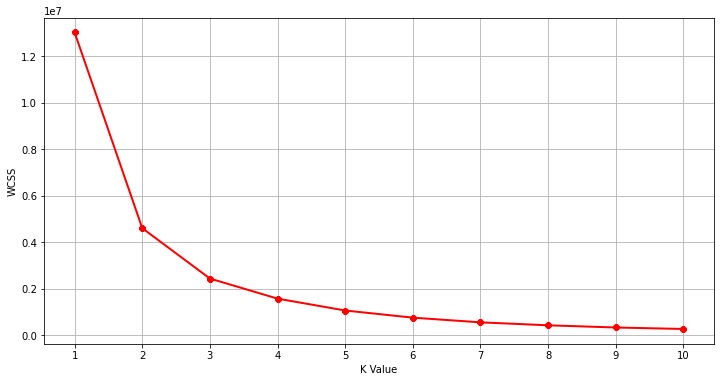

In [53]:
from sklearn.cluster import KMeans

#within-cluster sum of square
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(cluster2014.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [54]:
km = KMeans(n_clusters=5)

years = [cluster2014,cluster2015]
for i in years:
    clusters = km.fit_predict(i.iloc[:,1:])
    i["Cluster"] = clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [55]:
cluster2014['Cluster'].value_counts()

1    1236
4    1018
0     726
3     386
2      77
Name: Cluster, dtype: int64

In [56]:
cluster2015['Cluster'].value_counts()

2    1394
0    1034
4     590
1     249
3      47
Name: Cluster, dtype: int64

In [57]:
cluster2014

,Member_number,Year,Sales,Cluster
0,1000,2014,43.23,1
1,1001,2014,60.30,4
2,1002,2014,88.78,4
3,1003,2014,45.73,1
4,1004,2014,275.55,2
...,...,...,...,...
3438,4993,2014,110.07,0
3439,4995,2014,52.75,4
3440,4997,2014,20.04,1
3441,4999,2014,26.19,1


In [58]:
cluster2015

,Member_number,Year,Sales,Cluster
0,1000,2015,179.43,4
1,1001,2015,69.64,0
2,1002,2015,32.26,2
3,1003,2015,21.48,2
4,1004,2015,49.20,2
...,...,...,...,...
3309,4996,2015,97.97,0
3310,4997,2015,71.67,0
3311,4998,2015,13.80,2
3312,4999,2015,163.68,4


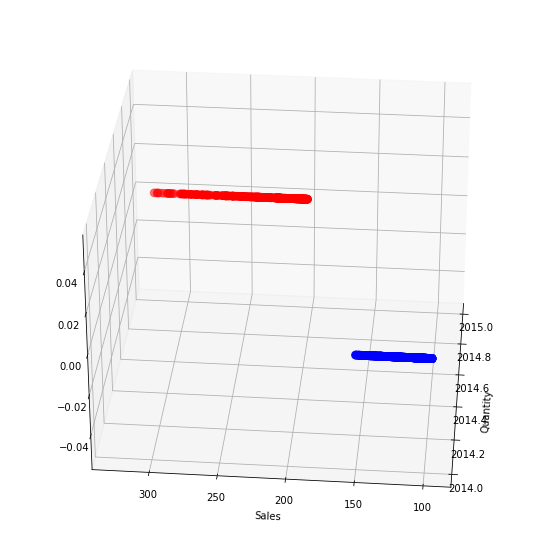

In [59]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster2014.Year[cluster2014.Cluster == 0], cluster2014["Sales"][cluster2014.Cluster == 0], c='blue', s=60)
ax.scatter(cluster2015.Year[cluster2015.Cluster == 1], cluster2015["Sales"][cluster2015.Cluster == 1], c='red', s=60)
ax.view_init(30, 185)
plt.xlabel("Quantity")
plt.ylabel("Sales")
plt.show()

In [61]:
cluster2014[cluster2014['Cluster'] == 0].describe()

,Member_number,Year,Sales,Cluster
count,726.000000,726.0,726.000000,726.0
mean,3053.453168,2014.0,120.711419,0.0
std,1161.176158,0.0,15.428864,0.0
min,1006.000000,2014.0,96.520000,0.0
25%,2077.500000,2014.0,107.495000,0.0
50%,3103.000000,2014.0,119.555000,0.0
75%,4069.500000,2014.0,133.182500,0.0
max,4993.000000,2014.0,151.450000,0.0


In [62]:
cluster2014[cluster2014['Cluster'] == 1].describe()

,Member_number,Year,Sales,Cluster
count,1236.000000,1236.0,1236.000000,1236.0
mean,2990.546926,2014.0,29.008592,1.0
std,1163.364790,0.0,12.232931,0.0
min,1000.000000,2014.0,2.030000,1.0
25%,1964.250000,2014.0,19.265000,1.0
50%,2985.000000,2014.0,29.375000,1.0
75%,4002.750000,2014.0,39.445000,1.0
max,4999.000000,2014.0,50.420000,1.0


In [63]:
cluster2014[cluster2014['Cluster'] == 2].describe()

,Member_number,Year,Sales,Cluster
count,77.000000,77.0,77.000000,77.0
mean,2810.168831,2014.0,290.863247,2.0
std,1175.606668,0.0,66.915071,0.0
min,1004.000000,2014.0,237.760000,2.0
25%,1862.000000,2014.0,248.660000,2.0
50%,2589.000000,2014.0,266.400000,2.0
75%,3782.000000,2014.0,301.830000,2.0
max,4969.000000,2014.0,540.250000,2.0


In [65]:
cluster2014[cluster2014['Cluster'] == 3].describe()

,Member_number,Year,Sales,Cluster
count,386.000000,386.0,386.000000,386.0
mean,3075.284974,2014.0,183.173187,3.0
std,1163.831608,0.0,22.210899,0.0
min,1010.000000,2014.0,152.160000,3.0
25%,2030.000000,2014.0,164.940000,3.0
50%,3125.000000,2014.0,178.390000,3.0
75%,4090.750000,2014.0,199.000000,3.0
max,4991.000000,2014.0,236.670000,3.0


In [66]:
cluster2014[cluster2014['Cluster'] == 4].describe()

,Member_number,Year,Sales,Cluster
count,1018.000000,1018.0,1018.000000,1018.0
mean,2971.377210,2014.0,71.906483,4.0
std,1138.705772,0.0,13.226003,0.0
min,1001.000000,2014.0,50.520000,4.0
25%,1980.500000,2014.0,60.472500,4.0
50%,2929.000000,2014.0,70.805000,4.0
75%,3952.250000,2014.0,82.700000,4.0
max,5000.000000,2014.0,96.290000,4.0


In [69]:
cluster2014['Cluster'] = cluster2014['Cluster'].replace({4:'Upper-Low-Value-Customer',2:'Upper-High-Value-Customer',0:'Average-Customer',1:'Low-Value-Customer',3:'High-Value-Customer'})
cluster2015['Cluster'] = cluster2015['Cluster'].replace({4:'Upper-Low-Value-Customer',2:'Upper-High-Value-Customer',0:'Average-Customer',1:'Low-Value-Customer',3:'High-Value-Customer'})

In [70]:
cluster2014

,Member_number,Year,Sales,Cluster
0,1000,2014,43.23,Low-Value-Customer
1,1001,2014,60.30,Upper-Low-Value-Customer
2,1002,2014,88.78,Upper-Low-Value-Customer
3,1003,2014,45.73,Low-Value-Customer
4,1004,2014,275.55,Upper-High-Value-Customer
...,...,...,...,...
3438,4993,2014,110.07,Average-Customer
3439,4995,2014,52.75,Upper-Low-Value-Customer
3440,4997,2014,20.04,Low-Value-Customer
3441,4999,2014,26.19,Low-Value-Customer


In [71]:
cluster2015

,Member_number,Year,Sales,Cluster
0,1000,2015,179.43,Upper-Low-Value-Customer
1,1001,2015,69.64,Average-Customer
2,1002,2015,32.26,Upper-High-Value-Customer
3,1003,2015,21.48,Upper-High-Value-Customer
4,1004,2015,49.20,Upper-High-Value-Customer
...,...,...,...,...
3309,4996,2015,97.97,Average-Customer
3310,4997,2015,71.67,Average-Customer
3311,4998,2015,13.80,Upper-High-Value-Customer
3312,4999,2015,163.68,Upper-Low-Value-Customer


In [72]:
cluster2014['Cluster'].value_counts()

Low-Value-Customer           1236
Upper-Low-Value-Customer     1018
Average-Customer              726
High-Value-Customer           386
Upper-High-Value-Customer      77
Name: Cluster, dtype: int64

In [73]:
cluster2015['Cluster'].value_counts()

Upper-High-Value-Customer    1394
Average-Customer             1034
Upper-Low-Value-Customer      590
Low-Value-Customer            249
High-Value-Customer            47
Name: Cluster, dtype: int64

<AxesSubplot:xlabel='Cluster', ylabel='count'>

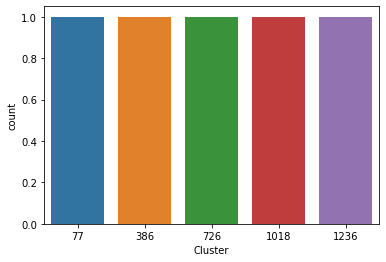

In [74]:
sns.countplot(cluster2014['Cluster'].value_counts())

<AxesSubplot:xlabel='Cluster', ylabel='count'>

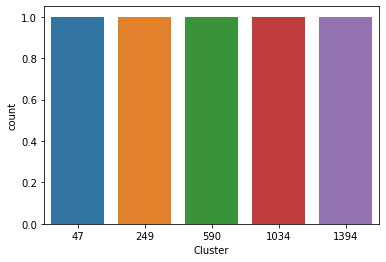

In [75]:
sns.countplot(cluster2015['Cluster'].value_counts())

In [85]:
finalcluster = cluster2014[['Member_number','Cluster']].rename({'Cluster':'2014'})
finalcluster['2015'] = cluster2015['Cluster'].rename({'Cluster':'2015'})
finalcluster.rename({'Cluster':'2014'},axis = 1,inplace = True)
finalcluster.fillna("No-Transactions",inplace = True)

In [86]:
finalcluster

,Member_number,2014,2015
0,1000,Low-Value-Customer,Upper-Low-Value-Customer
1,1001,Upper-Low-Value-Customer,Average-Customer
2,1002,Upper-Low-Value-Customer,Upper-High-Value-Customer
3,1003,Low-Value-Customer,Upper-High-Value-Customer
4,1004,Upper-High-Value-Customer,Upper-High-Value-Customer
...,...,...,...
3438,4993,Average-Customer,No-Transactions
3439,4995,Upper-Low-Value-Customer,No-Transactions
3440,4997,Low-Value-Customer,No-Transactions
3441,4999,Low-Value-Customer,No-Transactions


In [87]:
From_2014_2015 = pd.crosstab(finalcluster['2014'], finalcluster['2015'])

In [88]:
From_2014_2015

2015,Average-Customer,High-Value-Customer,Low-Value-Customer,No-Transactions,Upper-High-Value-Customer,Upper-Low-Value-Customer
2014,,,,,,
Average-Customer,219,14,51,29,294,119
High-Value-Customer,125,1,25,15,166,54
Low-Value-Customer,374,22,96,49,483,212
Upper-High-Value-Customer,23,0,9,2,34,9
Upper-Low-Value-Customer,293,10,68,34,417,196


C:\Users\pc\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\pc\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\pc\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\pc\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self

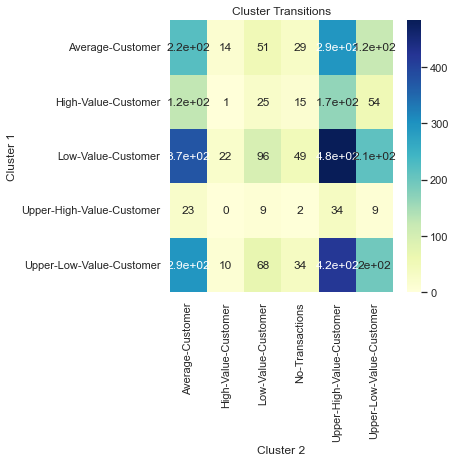

In [89]:
# Create heatmap
sns.set (rc = {'figure.figsize':(5,5)})
sns.heatmap(From_2014_2015, annot=True, cmap='YlGnBu')
# Set plot labels and title
plt.xlabel('Cluster 2')
plt.ylabel('Cluster 1')
plt.title('Cluster Transitions')
# Show the heatmap
plt.show()

# Forcasting using SES

In [35]:
for i in selected_members_20:
    a = Final_data[Final_data['Member_number'] == i]
    
    model = ExponentialSmoothing(a['Sales'].iloc[0:-2])
    ypred = model_fit.forecast(2)
    
    print("Customer Number is:- ",i)
    print('Values for the customer',i,'is:- ',a['Sales'].iloc[-1:].values[0])
    print('Values for the customer is:- ',ypred.values)

Customer Number is:-  4941
Values for the customer 4941 is:-  3.63
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  2193
Values for the customer 2193 is:-  12.96
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  1997
Values for the customer 1997 is:-  21.0
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  2421
Values for the customer 2421 is:-  32.0
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  1905
Values for the customer 1905 is:-  9.2
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  4783
Values for the customer 4783 is:-  7.0
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  3709
Values for the customer 3709 is:-  46.2
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  4272
Values for the customer 4272 is:-  3.78
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  2632
Values

Customer Number is:-  1793
Values for the customer 1793 is:-  10.18
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  4495
Values for the customer 4495 is:-  3.3
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  1878
Values for the customer 1878 is:-  38.5
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  3251
Values for the customer 3251 is:-  13.56
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  3761
Values for the customer 3761 is:-  9.6
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  2960
Values for the customer 2960 is:-  2.27
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  4574
Values for the customer 4574 is:-  30.0
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  1275
Values for the customer 1275 is:-  2.0
Values for the customer is:-  [14.3621002 14.3621002]
Customer Number is:-  4877
Values